In [1]:
# !pip install tensorflow

In [2]:
import tensorflow as tf
import os
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-09-28 10:36:03.074885: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-28 10:36:03.086182: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-28 10:36:03.089461: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-28 10:36:03.097591: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-28 10:36:03.741017: W tensorflow/compiler/tf2

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

I0000 00:00:1727544964.334220  173789 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727544964.347467  173789 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727544964.347508  173789 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
# Define the Inception module
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    # 1x1 convolution
    conv_1x1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
    
    # 1x1 convolution followed by 3x3 convolution
    conv_3x3 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = layers.Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)
    
    # 1x1 convolution followed by 5x5 convolution
    conv_5x5 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = layers.Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)
    
    # MaxPooling followed by 1x1 convolution
    max_pool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    max_pool = layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(max_pool)
    
    # Concatenate all the filters' outputs
    output = layers.concatenate([conv_1x1, conv_3x3, conv_5x5, max_pool], axis=-1)
    
    return output

# Define the full model
def googlenet(input_shape=(224, 224, 3), num_classes=10):
    inputs = layers.Input(shape=input_shape)
    
    # Initial Convolution and Max-Pooling layers
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    # Second Convolutional Block
    x = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    # First Inception module (3a)
    x = inception_module(x, filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128,
                         filters_5x5_reduce=16, filters_5x5=32, filters_pool_proj=32)
    
    # Second Inception module (3b)
    x = inception_module(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192,
                         filters_5x5_reduce=32, filters_5x5=96, filters_pool_proj=64)
    
    # Max-Pooling
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    # Third Inception module (4a)
    x = inception_module(x, filters_1x1=192, filters_3x3_reduce=96, filters_3x3=208,
                         filters_5x5_reduce=16, filters_5x5=48, filters_pool_proj=64)
    
    # Fourth Inception module (4b)
    x = inception_module(x, filters_1x1=160, filters_3x3_reduce=112, filters_3x3=224,
                         filters_5x5_reduce=24, filters_5x5=64, filters_pool_proj=64)
    
    # Fifth Inception module (4c)
    x = inception_module(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=256,
                         filters_5x5_reduce=24, filters_5x5=64, filters_pool_proj=64)
    
    # Max-Pooling
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)
    
    # Dropout
    x = layers.Dropout(0.4)(x)
    
    # Fully Connected (Output Layer)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    # Create the model
    model = models.Model(inputs, outputs)
    
    return model

# Create the model
IMG_HEIGHT = 224
IMG_WIDTH = 224
NUM_CLASSES = 10
LEARNING_RATE = 0.0001

input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

model = googlenet(input_shape=input_shape, num_classes=NUM_CLASSES)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Compile the model
model.compile(optimizer=optimizer, 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Model Summary
model.summary()


I0000 00:00:1727544964.362214  173789 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727544964.362278  173789 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727544964.362298  173789 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727544964.464946  173789 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727544964.465013  173789 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-28

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │    110,784 │ max_pooling2d[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 28, 28,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │     18,528 │ max_pooling2d_1[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 28,    │      3,088 │ max_pooling2d_1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ max_pooling2d_1[… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     12,352 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │    110,720 │ conv2d_3[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │     12,832 │ conv2d_5[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │      6,176 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 28,    │          0 │ conv2d_2[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_4[0][0],   │
│                     │                   │            │ conv2d_6[0][0],   │
│                     │                   │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 28, 28,    │     32,896 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 28, 28,    │      8,224 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 28, 28,    │          0 │ concatenate[0][0] │
│ (MaxPooling2D)      │ 256)              │            │                 

 Total params: 2,013,258 (7.68 MB)

 Trainable params: 2,013,258 (7.68 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Data Augmentation setup
train_datagen = ImageDataGenerator(
    rotation_range=20,          # Rotate images by up to 20 degrees
    width_shift_range=0.2,      # Shift images horizontally by up to 20%
    height_shift_range=0.2,     # Shift images vertically by up to 20%
    shear_range=0.2,            # Shear transformation
    zoom_range=0.2,             # Zoom in on images by up to 20%
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Fill in missing pixels after transformations
)

# Load training data from directories
IMAGE_DIR = os.path.join(os.getcwd(), "..", "data", "imagenet_224")
BATCH_SIZE = 16
TARGET_SIZE = (IMG_WIDTH, IMG_HEIGHT)

# Image Dataset from Directory setup
# Automatically split the data into training (80%) and validation (20%)
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    IMAGE_DIR,           # Replace with the path to your image directory
    validation_split=0.2,       # Use 20% of the data for validation
    subset="training",          # Use the training split
    seed=42,                    # Set a seed to ensure repeatability
    image_size=TARGET_SIZE,      # Resize images to 224x224
    batch_size=BATCH_SIZE               # Batch size for training
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    IMAGE_DIR,           # Same path to images
    validation_split=0.2,       # Use 20% of the data for validation
    subset="validation",        # Use the validation split
    seed=42,                    # Set a seed to ensure repeatability
    image_size=TARGET_SIZE,      # Resize images to 224x224
    batch_size=BATCH_SIZE               # Batch size for validation
)

Found 14738 files belonging to 10 classes.
Using 11791 files for training.
Found 14738 files belonging to 10 classes.
Using 2947 files for validation.


In [6]:
# Apply data augmentation to the training dataset
augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

# Apply the augmentation only on the training dataset
train_dataset = train_dataset.map(lambda x, y: (augmentation(x, training=True), y))

# Prefetch the datasets for performance improvement
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [7]:
# Train the model
EPOCHS = 30

history = model.fit(
    train_dataset,
    epochs=EPOCHS,                         # Adjust number of epochs as needed
    validation_data=validation_dataset
)

Epoch 1/30


I0000 00:00:1727544984.932120  173887 service.cc:146] XLA service 0x7fa3d4003290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727544984.932160  173887 service.cc:154]   StreamExecutor device (0): Quadro P2000, Compute Capability 6.1
2024-09-28 10:36:25.050931: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-28 10:36:25.720991: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-09-28 10:37:04.409707: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_18', 4 bytes spill stores, 12 bytes spill loads

I0000 00:00:1727545024.438484

736/737 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.1871 - loss: 2.6138

2024-09-28 10:39:50.154149: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_18', 4 bytes spill stores, 12 bytes spill loads



737/737 ━━━━━━━━━━━━━━━━━━━━ 239s 264ms/step - accuracy: 0.1872 - loss: 2.6124 - val_accuracy: 0.3142 - val_loss: 1.8771
Epoch 2/30
737/737 ━━━━━━━━━━━━━━━━━━━━ 138s 187ms/step - accuracy: 0.3175 - loss: 1.8410 - val_accuracy: 0.3753 - val_loss: 1.6784
Epoch 3/30
737/737 ━━━━━━━━━━━━━━━━━━━━ 139s 188ms/step - accuracy: 0.3715 - loss: 1.7052 - val_accuracy: 0.3475 - val_loss: 1.7876
Epoch 4/30
737/737 ━━━━━━━━━━━━━━━━━━━━ 138s 187ms/step - accuracy: 0.4146 - loss: 1.6209 - val_accuracy: 0.4031 - val_loss: 1.6337
Epoch 5/30
737/737 ━━━━━━━━━━━━━━━━━━━━ 138s 187ms/step - accuracy: 0.4506 - loss: 1.5270 - val_accuracy: 0.4632 - val_loss: 1.4663
Epoch 6/30
737/737 ━━━━━━━━━━━━━━━━━━━━ 138s 187ms/step - accuracy: 0.4764 - loss: 1.4456 - val_accuracy: 0.5100 - val_loss: 1.3816
Epoch 7/30
737/737 ━━━━━━━━━━━━━━━━━━━━ 138s 187ms/step - accuracy: 0.5028 - loss: 1.3948 - val_accuracy: 0.5317 - val_loss: 1.3225
Epoch 8/30
737/737 ━━━━━━━━━━━━━━━━━━━━ 138s 187ms/step - accuracy: 0.5238 - loss: 1.33

In [8]:
model.save(os.path.join("../data", "model_googlenet_complex.keras"))

In [9]:
import pickle

with open(os.path.join("../data", "history_googlenet_complex.pkl"), "wb") as file:
    pickle.dump(history, file)

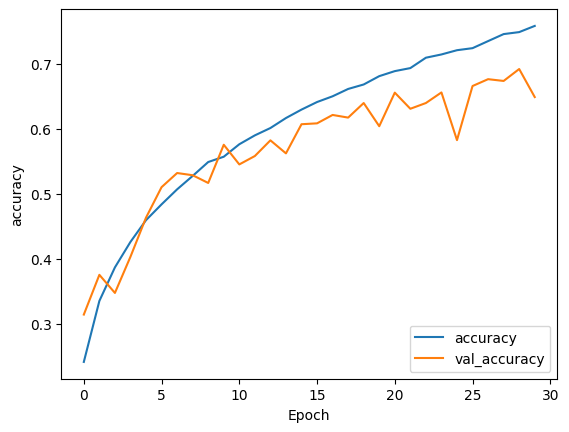

In [10]:
import matplotlib.pyplot as plt

def plot_accuracy_curve(training_result, metric):
    val_metric = f"val_{metric}"
    train_perf = training_result.history[metric]
    validation_perf = training_result.history[val_metric]
    
    plt.plot(train_perf, label=metric)
    plt.plot(validation_perf, label=val_metric)
    
    max_val = max(validation_perf)
    max_val_epoch = validation_perf.index(max_val)
    
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.legend(loc="lower right")
    
plot_accuracy_curve(history, "accuracy")  
# plot_accuracy_curve(history, "categorical_accuracy")
# plot_accuracy_curve(history, "top_k_categorical_accuracy")
# plot_accuracy_curve(history, "loss")

In [11]:
# Get the training accuracy values across epochs
train_acc = history.history['accuracy']

# Get the validation accuracy values across epochs (if needed)
val_acc = history.history['val_accuracy']

# Find the maximum accuracy and the corresponding epoch (for training)
max_train_acc = max(train_acc)
max_train_epoch = train_acc.index(max_train_acc) + 1  # Add 1 to get the correct epoch (since epochs are 1-indexed)

# If you want to find the max validation accuracy as well:
max_val_acc = max(val_acc)
max_val_epoch = val_acc.index(max_val_acc) + 1

# Print the results
print(f"Max Training Accuracy: {max_train_acc:.4f} at epoch {max_train_epoch}")
print(f"Max Validation Accuracy: {max_val_acc:.4f} at epoch {max_val_epoch}")

Max Training Accuracy: 0.7578 at epoch 30
Max Validation Accuracy: 0.6916 at epoch 29


In [12]:
# Extract training and validation accuracy values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Calculate the absolute difference between training and validation accuracy for each epoch
acc_diff = [abs(train - val) for train, val in zip(train_acc, val_acc)]

# Find the minimum difference and the corresponding epoch
min_diff = min(acc_diff)
min_diff_epoch = acc_diff.index(min_diff) + 1  # Add 1 to match the epoch (1-indexed)

# Print the results
print(f"Minimum difference between accuracy and validation accuracy: {min_diff:.4f} at epoch {min_diff_epoch}")

Minimum difference between accuracy and validation accuracy: 0.0011 at epoch 8
